In [ ]:
import pandas as pd
df_amazon_women = pd.read_csv("scraped_data/Amazon_women.csv", thousands = ',')
df_amazon_men = pd.read_csv("scraped_data/Amazon_Men.csv", thousands = ',')
df_myntra_men = pd.read_csv("scraped_data/myntra_men_latest.csv")
df_myntra_women = pd.read_csv("scraped_data/myntra_women_latest.csv")

df_myntra_men = df_myntra_men.dropna()
df_myntra_women = df_myntra_women.dropna()

df_myntra_men.rename(columns = {'image': 'Links', 'rating': 'Rating', 'reviews' : 'Reviews'}, inplace = True)
df_myntra_women.rename(columns = {'image': 'Links', 'rating': 'Rating', 'reviews' : 'Reviews'}, inplace = True)

In [ ]:
df_myntra_men["Reviews"] = df_myntra_men["Reviews"].str.split(expand=True)[0]

df_myntra_men.Reviews = (df_myntra_men.Reviews.replace(r'[Kk]+$', '', regex=True).astype(float) * df_myntra_men.Reviews.str.extract(r'[\d\.]+([Kk]+)', expand=False).fillna(1).replace(['K','k'], [10**3, 10**3]).astype(int))

In [ ]:
df_myntra_women["Reviews"] = df_myntra_women["Reviews"].str.split(expand=True)[0]

df_myntra_women.Reviews = (df_myntra_women.Reviews.replace(r'[Kk]+$', '', regex=True).astype(float) * df_myntra_women.Reviews.str.extract(r'[\d\.]+([Kk]+)', expand=False).fillna(1).replace(['K','k'], [10**3, 10**3]).astype(int))

In [ ]:
for i in range(len(df_amazon_men)):
  try:
    df_amazon_men.iloc[i][3] = df_amazon_men.iloc[i][3].split(" ")[0].replace(",", "")
  except:
    pass

for i in range(len(df_amazon_women)):
  try:
    df_amazon_women.iloc[i][3] = df_amazon_women.iloc[i][3].split(" ")[0].replace(",", "")
  except:
    pass

df_amazon_men["Reviews"] = df_amazon_men["Reviews"].astype('int32')
df_amazon_women["Reviews"] = df_amazon_women["Reviews"].astype('int32')

In [ ]:
df_amazon = pd.read_csv("scraped_data/df_amazon.csv", thousands = ',')
df_flipkart = pd.read_csv("scraped_data/df_flipkart.csv", thousands = ',')

df_amazon = df_amazon.drop(columns=["Unnamed: 0"])

for i in range(len(df_amazon)):
  try:
    df_amazon.iloc[i][1] = df_amazon.iloc[i][1].split(" ")[0]
  except:
    pass
  try:
    df_amazon.iloc[i][2] = df_amazon.iloc[i][2].split(" ")[0].replace(",", "")
  except:
    pass

df_flipkart = df_flipkart.drop(columns=["Unnamed: 0"])

for i in range(len(df_flipkart)):
  try:
    df_flipkart.iloc[i][1] = df_flipkart.iloc[i][1].split(" ")[0]
  except:
    pass
  try:
    df_flipkart.iloc[i][2] = df_flipkart.iloc[i][2].split(" ")[0].replace(",", "")
  except:
    pass

In [ ]:
df_amazon["rating"] = df_amazon["rating"].astype('float32')
df_amazon["no_of_reviews"] = df_amazon["no_of_reviews"].astype('int32')

df_flipkart["rating"] = df_flipkart["rating"].astype('float32')
df_flipkart["no_of_reviews"] = df_flipkart["no_of_reviews"].astype('int32')

In [ ]:
df_amazon.rename(columns = {'img_links': 'Links', 'rating': 'Rating', 'no_of_reviews' : 'Reviews'}, inplace = True)
df_flipkart.rename(columns = {'img_links': 'Links', 'rating': 'Rating', 'no_of_reviews' : 'Reviews'}, inplace = True)

In [ ]:
df_amazon_women.head()

In [ ]:
df_merged = pd.concat([df_amazon, df_flipkart, df_amazon_men, df_amazon_women, df_myntra_men, df_myntra_women], axis=0, ignore_index=True)

In [ ]:
df_merged = df_merged[["Links", "Rating", "Reviews"]]

In [ ]:
def pop_met(n, s):
    top = s*(15+n)*1.0
    bott = n+5*s*1.0
    pm = top/bott
    return pm

df_merged["popularity"] = pop_met(df_merged["Reviews"], df_merged["Rating"])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_merged["popularity"])

In [ ]:
import urllib.request

for i in range(len(df_merged)):
    pop = df_merged.loc[i]["popularity"]
    url = df_merged.loc[i]["Links"]
    #print(url)
    #print(pop)
    if(pop < 3): urllib.request.urlretrieve(url, "dataset/0/c" + str(i) + ".jpg")
    elif(pop >= 3 and pop < 3.5) : urllib.request.urlretrieve(url, "dataset/1/c" + str(i) + ".jpg")
    elif(pop >= 3.5 and pop < 4) : urllib.request.urlretrieve(url, "dataset/2/c" + str(i) + ".jpg")
    else: urllib.request.urlretrieve(url, "dataset/3/c" + str(i) + ".jpg")

In [ ]:
df_merged.head()

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

data_dir = "dataset"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  shuffle = True,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  shuffle = True,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 3029 files belonging to 4 classes.
Using 2424 files for training.
Found 3029 files belonging to 4 classes.
Using 605 files for validation.


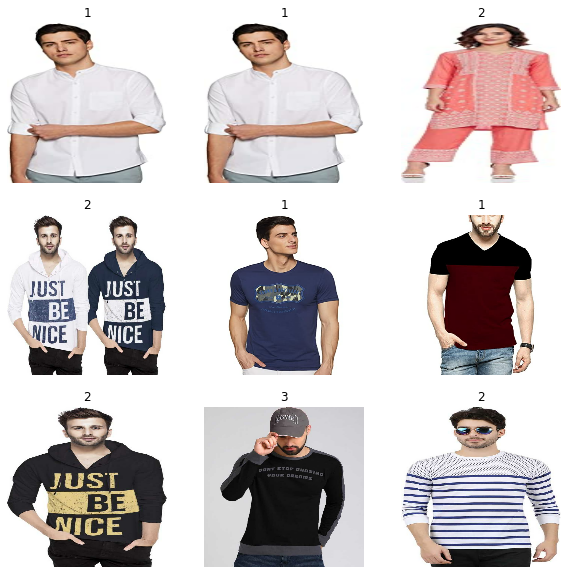

In [3]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16

IMG_SHAPE = IMG_SIZE + (3,)
model = VGG16(weights="imagenet", include_top=False, input_shape = IMG_SHAPE)

In [7]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


In [8]:
model.trainable = False

In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [10]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [11]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = rescale(inputs)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\users\my\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

19/19 [==============================] - 21s 1s/step - loss: 2.2317 - accuracy: 0.1851


In [14]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
76/76 [==============================] - 100s 1s/step - loss: 1.9966 - accuracy: 0.2108 - val_loss: 1.7462 - val_accuracy: 0.2099
Epoch 2/10
76/76 [==============================] - 97s 1s/step - loss: 1.5875 - accuracy: 0.2859 - val_loss: 1.4153 - val_accuracy: 0.2413
Epoch 3/10
76/76 [==============================] - 98s 1s/step - loss: 1.3439 - accuracy: 0.3342 - val_loss: 1.2505 - val_accuracy: 0.3554
Epoch 4/10
76/76 [==============================] - 97s 1s/step - loss: 1.2467 - accuracy: 0.3919 - val_loss: 1.1930 - val_accuracy: 0.4496
Epoch 5/10
76/76 [==============================] - 103s 1s/step - loss: 1.1969 - accuracy: 0.4233 - val_loss: 1.1747 - val_accuracy: 0.4512
Epoch 6/10
76/76 [==============================] - 101s 1s/step - loss: 1.1883 - accuracy: 0.4286 - val_loss: 1.1662 - val_accuracy: 0.4628
Epoch 7/10
76/76 [==============================] - 102s 1s/step - loss: 1.1635 - accuracy: 0.4431 - val_loss: 1.1598 - val_accuracy: 0.4678
Epoch 8/10
76/76

In [16]:
model.save("image_model_v2")

INFO:tensorflow:Assets written to: image_model_v2\assets


In [17]:
model.save("image_model_v2.h5")